[Info] Calculating Static Beta & Z-Score (robust)...
  WINDOW_BETA = 3500, WINDOW_Z = 150
  MIN_BETA_PERIOD = 350, MIN_Z_PERIOD = 15
[Info] Rows total: 122630, rows with Z_Score: 117541 (>=0 means usable)
[Info] Simulating Pairs Strategy: ENTRY=2.0, EXIT=0.5
[Info] Total trade events (approx): 531.0

 PERFORMANCE REPORT: Static Cointegration Strategy (CAD/AUD)


,Quarter,Gross SR,Net SR,Ann. Vol ($),Gross CR,Net CR,Gross CumP&L,Net CumP&L,Trades (CAD),Trades (AUD),Av. Trades,Stat
0,2023_Q1,1.913606,0.891144,5527.574588,1.913606,1.800940,3264.672379,1524.672379,87.0,87.0,2.230769,0.164977
1,2023_Q3,1.227257,0.237440,4951.599260,1.227257,0.468419,1863.909706,363.909706,75.0,75.0,1.923077,-0.000000
2,2023_Q4,0.786478,-0.332872,4219.132752,0.786478,-0.567361,1025.295006,-434.704994,73.0,73.0,1.871795,-0.000000
3,2024_Q2,0.143602,-0.921209,3818.968216,0.143602,-1.101935,177.113089,-1102.886911,64.0,64.0,1.620253,-0.139181
4,2024_Q4,0.354383,-0.448046,4370.515800,0.354383,-0.539525,506.122407,-613.877593,56.0,56.0,1.417722,-0.000000
5,2025_Q1,1.364952,-0.415681,2995.823444,1.364952,-0.618864,1219.489273,-380.510727,80.0,80.0,2.077922,-0.000000
6,2025_Q2,0.605260,-0.637233,4899.502074,0.605260,-1.205415,941.238539,-978.761461,96.0,96.0,2.430380,-0.000000
7,TOTAL,NaN,NaN,4445.322544,NaN,NaN,8997.840398,-1622.159602,531.0,531.0,1.938845,0.025796



 TOTAL RANKING SCORE: 0.0258


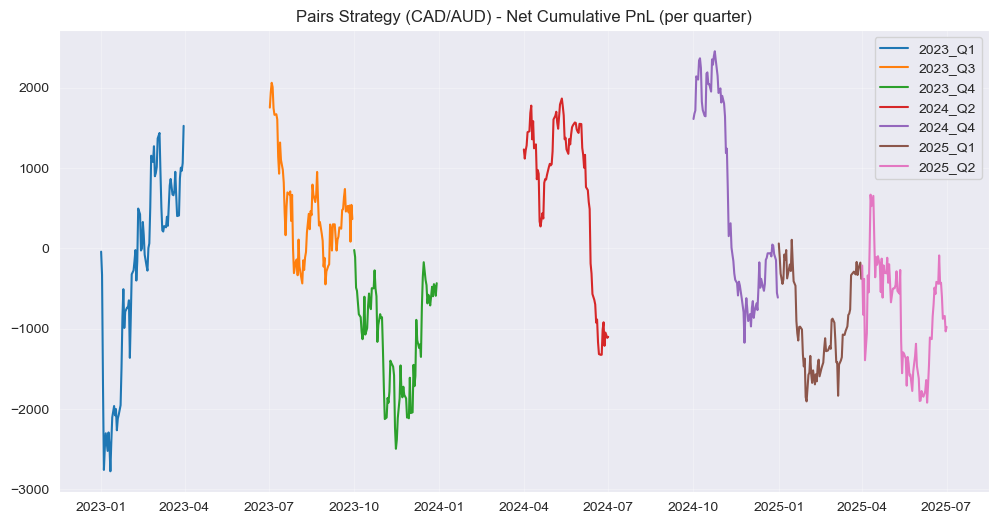

In [49]:
            import pandas as pd
            import numpy as np
            import matplotlib.pyplot as plt
            from IPython.display import display
            import warnings

            warnings.filterwarnings('ignore')


            class Config:
                # File Path
                FILE_PATH = '../../preprocess/df_g2_processed.pkl'
                ASSETS = ['CAD', 'AUD']  # CAD = Y, AUD = X

                # Contract Specs
                SPECS = {
                    'CAD': {'point_val': 100000.0, 'cost': 10.0},
                    'AUD': {'point_val': 100000.0, 'cost': 10.0}
                }

                # --- Strategy Parameters (keep semantics unchanged) ---
                WINDOW_BETA = 3500 # rolling window for beta
                WINDOW_Z = 150       # rolling window for z-score
                ENTRY_THRESHOLD = 2.0

                EXIT_THRESHOLD = 0.5


                ANNUALIZATION = 252

                # Robustness knobs (internal, safe defaults)
                MIN_BETA_PERIOD = max(10, int(WINDOW_BETA * 0.1))  # min periods to compute beta
                MIN_Z_PERIOD = max(10, int(WINDOW_Z * 0.1))




            # --------------------------
            # 2. Data preparation
            # --------------------------
            def prepare_pairs_data(file_path, cfg):
                """
                Loads data and computes rolling beta and z-score.
                Preserves per-quarter grouping while being robust to small quarter lengths.
                Returns a DataFrame with additional columns: Beta, Spread, Z_Score.
                """
                try:
                    df = pd.read_pickle(file_path)
                except FileNotFoundError:
                    print(f"[Error] File not found: {file_path}")
                    return None

                # Required columns: CAD, AUD, Quarter_ID
                req_cols = set(cfg.ASSETS + ['Quarter_ID'])
                if not req_cols.issubset(df.columns):
                    missing = req_cols.difference(df.columns)
                    print(f"[Error] Missing required columns: {missing}")
                    return None

                data = df[cfg.ASSETS + ['Quarter_ID'] + (['Is_In_Sample'] if 'Is_In_Sample' in df.columns else [])].copy()
                if 'Is_In_Sample' not in data.columns:
                    data['Is_In_Sample'] = True

                print("[Info] Calculating Static Beta & Z-Score (robust)...")
                print(f"  WINDOW_BETA = {cfg.WINDOW_BETA}, WINDOW_Z = {cfg.WINDOW_Z}")
                print(f"  MIN_BETA_PERIOD = {cfg.MIN_BETA_PERIOD}, MIN_Z_PERIOD = {cfg.MIN_Z_PERIOD}")

                # We'll compute on each Quarter_ID but with safe min_periods to avoid entire-quarter NaN
                def calc_cointegration_metrics(group):
                    g = group.copy()

                    # convert to notional (price * point_val) for beta calc as in your original code
                    y = g['CAD'] * cfg.SPECS['CAD']['point_val']   # Y
                    x = g['AUD'] * cfg.SPECS['AUD']['point_val']   # X

                    # Rolling cov and var with min_periods for robustness
                    cov = x.rolling(window=cfg.WINDOW_BETA, min_periods=cfg.MIN_BETA_PERIOD).cov(y)
                    var = x.rolling(window=cfg.WINDOW_BETA, min_periods=cfg.MIN_BETA_PERIOD).var()

                    # Avoid division by zero: set var very small -> NaN
                    var_safe = var.copy()
                    var_safe[var_safe.abs() < 1e-8] = np.nan

                    beta = cov / var_safe

                    # Clean up infinities/nans: forward/backfill then default 1.0
                    beta = beta.replace([np.inf, -np.inf], np.nan).ffill().bfill().fillna(1.0)

                    # Spread in notional units
                    spread = y - (beta * x)

                    # Z-score rolling with min_periods
                    spread_mean = spread.rolling(window=cfg.WINDOW_Z, min_periods=cfg.MIN_Z_PERIOD).mean()
                    spread_std = spread.rolling(window=cfg.WINDOW_Z, min_periods=cfg.MIN_Z_PERIOD).std()

                    # avoid division by zero
                    spread_std_safe = spread_std.copy()
                    spread_std_safe[spread_std_safe.abs() < 1e-12] = np.nan

                    z_score = (spread - spread_mean) / spread_std_safe

                    # Align into DataFrame columns (use original index)
                    g.loc[:, 'Beta'] = beta.values
                    g.loc[:, 'Spread'] = spread.values
                    g.loc[:, 'Z_Score'] = z_score.values

                    return g

                # Apply per Quarter_ID but keep index alignment
                data_out = data.groupby('Quarter_ID', group_keys=False).apply(calc_cointegration_metrics)

                # Report how many rows have valid Z
                n_total = len(data_out)
                n_z = data_out['Z_Score'].notna().sum()
                print(f"[Info] Rows total: {n_total}, rows with Z_Score: {n_z} (>=0 means usable)")

                # Do not force-drop all NaNs; keep rows (strategy will skip NaN z)
                return data_out


            # --------------------------
            # 3. Strategy logic
            # --------------------------
            def run_pairs_strategy(df, cfg):
                """
                Executes trades from Z-Score signals.
                Strategy logic unchanged: entry when |z| > ENTRY, exit when |z| < EXIT.
                Positions are lagged by 1 bar (shift) to avoid look-ahead.
                """
                data = df.copy()
                if data.empty:
                    print("[Warning] Empty DataFrame passed to strategy.")
                    return data

                # Prepare arrays
                z = data['Z_Score'].values
                in_sample = data['Is_In_Sample'].values if 'Is_In_Sample' in data.columns else np.ones(len(data), dtype=bool)

                pos_cad = np.zeros(len(data), dtype=int)
                pos_aud = np.zeros(len(data), dtype=int)
                curr_cad = 0
                curr_aud = 0

                print(f"[Info] Simulating Pairs Strategy: ENTRY={cfg.ENTRY_THRESHOLD}, EXIT={cfg.EXIT_THRESHOLD}")

                for i in range(len(data)):
                    if not in_sample[i]:
                        curr_cad = 0
                        curr_aud = 0
                        pos_cad[i] = 0
                        pos_aud[i] = 0
                        continue

                    zi = z[i]
                    # If z is NaN, do nothing (hold current pos)
                    if np.isnan(zi):
                        pos_cad[i] = curr_cad
                        pos_aud[i] = curr_aud
                        continue

                    # Entry
                    if curr_cad == 0 and curr_aud == 0:
                        if zi > cfg.ENTRY_THRESHOLD:
                            # Sell spread: Sell CAD, Buy AUD
                            curr_cad = -1
                            curr_aud = 1
                        elif zi < -cfg.ENTRY_THRESHOLD:
                            curr_cad = 1
                            curr_aud = -1
                    else:
                        # Exit when abs(z) < EXIT_THRESHOLD
                        if abs(zi) < cfg.EXIT_THRESHOLD:
                            curr_cad = 0
                            curr_aud = 0

                    pos_cad[i] = curr_cad
                    pos_aud[i] = curr_aud

                # Lag positions by 1 bar to simulate execution on next bar
                data['Pos_CAD'] = pd.Series(pos_cad, index=data.index).shift(1).fillna(0).astype(int)
                data['Pos_AUD'] = pd.Series(pos_aud, index=data.index).shift(1).fillna(0).astype(int)

                # Add a debug summary
                n_trades = (data['Pos_CAD'].diff().abs().sum() + data['Pos_AUD'].diff().abs().sum()) / 2.0
                print(f"[Info] Total trade events (approx): {n_trades}")

                return data


            # --------------------------
            # 4. P&L calculation & aggregation
            # --------------------------
            def calculate_metrics(data, cfg):
                df = data.copy()
                if df.empty:
                    return pd.DataFrame()

                # Price diffs (raw prices)
                df['dPrice_CAD'] = df['CAD'].diff()
                df['dPrice_AUD'] = df['AUD'].diff()

                # Gross PnL: position * price change * point value
                df['Gross_PnL_CAD'] = df['Pos_CAD'] * df['dPrice_CAD'] * cfg.SPECS['CAD']['point_val']
                df['Gross_PnL_AUD'] = df['Pos_AUD'] * df['dPrice_AUD'] * cfg.SPECS['AUD']['point_val']
                df['Gross_PnL_Total'] = df['Gross_PnL_CAD'].fillna(0) + df['Gross_PnL_AUD'].fillna(0)

                # Trades & costs
                df['Trades_CAD'] = df['Pos_CAD'].diff().abs().fillna(0)
                df['Trades_AUD'] = df['Pos_AUD'].diff().abs().fillna(0)
                df['Cost_Total'] = (df['Trades_CAD'] * cfg.SPECS['CAD']['cost']) + (df['Trades_AUD'] * cfg.SPECS['AUD']['cost'])

                df['Net_PnL_Total'] = df['Gross_PnL_Total'] - df['Cost_Total']
                df['Total_Trades'] = df['Trades_CAD'] + df['Trades_AUD']

                # Daily aggregation
                daily_stats = df.resample('D').agg({
                    'Gross_PnL_Total': 'sum',
                    'Net_PnL_Total': 'sum',
                    'Total_Trades': 'sum',
                    'Trades_CAD': 'sum',
                    'Trades_AUD': 'sum',
                    'Quarter_ID': 'last',
                    'Is_In_Sample': 'last'
                })

                # Filter only valid quarters and in-sample days
                daily_stats = daily_stats[daily_stats['Quarter_ID'].notna()]
                daily_stats = daily_stats[daily_stats['Is_In_Sample'] == True]

                return daily_stats


            # --------------------------
            # 5. Reporting
            # --------------------------
            def generate_quarterly_stats(daily_df, cfg):
                if daily_df.empty:
                    return pd.DataFrame()

                quarters = sorted(daily_df['Quarter_ID'].unique())
                stats_list = []

                for q in quarters:
                    d_q = daily_df[daily_df['Quarter_ID'] == q].copy()
                    if len(d_q) == 0:
                        continue

                    gross_cum_pnl = d_q['Gross_PnL_Total'].sum()
                    net_cum_pnl = d_q['Net_PnL_Total'].sum()

                    mean_g = d_q['Gross_PnL_Total'].mean()
                    std_g = d_q['Gross_PnL_Total'].std()
                    gross_sr = (mean_g / std_g * np.sqrt(cfg.ANNUALIZATION)) if (std_g and not np.isnan(std_g)) else 0

                    mean_n = d_q['Net_PnL_Total'].mean()
                    std_n = d_q['Net_PnL_Total'].std()
                    net_sr = (mean_n / std_n * np.sqrt(cfg.ANNUALIZATION)) if (std_n and not np.isnan(std_n)) else 0

                    ann_vol_n = std_n * np.sqrt(cfg.ANNUALIZATION) if (std_n and not np.isnan(std_n)) else 0

                    years = len(d_q) / cfg.ANNUALIZATION if cfg.ANNUALIZATION > 0 else 1.0

                    equity_n = d_q['Net_PnL_Total'].cumsum()
                    max_dd_n = (equity_n.cummax() - equity_n).max()
                    net_cr = (net_cum_pnl / years / max_dd_n) if (max_dd_n and max_dd_n > 0) else 0

                    trades_cad = d_q['Trades_CAD'].sum()
                    trades_aud = d_q['Trades_AUD'].sum()
                    av_ntrades = d_q['Total_Trades'].mean()

                    abs_pnl_scaled = abs(net_cum_pnl) / 1000.0
                    log_term = np.log(abs_pnl_scaled) if abs_pnl_scaled > 0 else 0
                    term_2 = max(0, log_term)
                    stat = (net_sr - 0.5) * term_2

                    stats_list.append({
                        'Quarter': q,
                        'Gross SR': gross_sr,
                        'Net SR': net_sr,
                        'Ann. Vol ($)': ann_vol_n,
                        'Gross CR': 0.0 if np.isnan(gross_sr) else gross_sr,
                        'Net CR': net_cr,
                        'Gross CumP&L': gross_cum_pnl,
                        'Net CumP&L': net_cum_pnl,
                        'Trades (CAD)': trades_cad,
                        'Trades (AUD)': trades_aud,
                        'Av. Trades': av_ntrades,
                        'Stat': stat
                    })

                return pd.DataFrame(stats_list)


            def plot_equity_curve(daily_stats):
                if daily_stats is None or daily_stats.empty:
                    return
                quarters = sorted(daily_stats['Quarter_ID'].unique())
                plt.figure(figsize=(12, 6))
                for q in quarters:
                    d_q = daily_stats[daily_stats['Quarter_ID'] == q].copy()
                    plt.plot(d_q.index, d_q['Net_PnL_Total'].cumsum(), label=q)
                plt.title('Pairs Strategy (CAD/AUD) - Net Cumulative PnL (per quarter)')
                plt.legend()
                plt.grid(True, alpha=0.3)
                plt.show()


            # --------------------------
            # 6. Main
            # --------------------------
            if __name__ == "__main__":
                cfg = Config()
                df_prep = prepare_pairs_data(cfg.FILE_PATH, cfg)

                if df_prep is None or df_prep.empty:
                    print("[Error] No data after preparation. Exiting.")
                else:
                    df_res = run_pairs_strategy(df_prep, cfg)
                    daily_data = calculate_metrics(df_res, cfg)
                    stats_table = generate_quarterly_stats(daily_data, cfg)

                    print("\n" + "=" * 80)
                    print(" PERFORMANCE REPORT: Static Cointegration Strategy (CAD/AUD)")
                    print("=" * 80)

                    if not stats_table.empty:
                        total_score = stats_table['Stat'].sum()
                        total_gross_pnl = stats_table['Gross CumP&L'].sum()
                        total_net_pnl = stats_table['Net CumP&L'].sum()
                        total_trades_cad = stats_table['Trades (CAD)'].sum()
                        total_trades_aud = stats_table['Trades (AUD)'].sum()

                        std_global = daily_data['Net_PnL_Total'].std()
                        vol_global = std_global * np.sqrt(cfg.ANNUALIZATION) if not np.isnan(std_global) else 0.0

                        display_df = stats_table.copy()
                        sum_row = pd.DataFrame([{
                            'Quarter': 'TOTAL',
                            'Gross SR': np.nan,
                            'Net SR': np.nan,
                            'Ann. Vol ($)': vol_global,
                            'Gross CR': np.nan,
                            'Net CR': np.nan,
                            'Gross CumP&L': total_gross_pnl,
                            'Net CumP&L': total_net_pnl,
                            'Trades (CAD)': total_trades_cad,
                            'Trades (AUD)': total_trades_aud,
                            'Av. Trades': stats_table['Av. Trades'].mean(),
                            'Stat': total_score
                        }])

                        display_df = pd.concat([display_df, sum_row], ignore_index=True)
                        display(display_df)

                        print(f"\n{'=' * 40}")
                        print(f" TOTAL RANKING SCORE: {total_score:.4f}")
                        print(f"{'=' * 40}")

                        plot_equity_curve(daily_data)
                    else:
                        print("⚠️ No statistics generated.")


[Info] Calculating Beta & Z-Score (robust, per quarter)...
  WINDOW_BETA = 3500, WINDOW_Z = 150
  MIN_BETA_PERIOD = 350, MIN_Z_PERIOD = 15
[Info] Rows total: 122630, rows with Z_Score: 117541
[Info] Running pairs strategy with break-window rules and unit positions (-1/0/1). ENTRY=2.0, EXIT=0.5
[Info] Total trade events (approx): 531.0

 PERFORMANCE REPORT: Pairs Strategy (CAD/AUD) with Break Rules


,Quarter,Gross SR,Net SR,Ann. Vol ($),Gross CR,Net CR,Gross CumP&L,Net CumP&L,Trades (CAD),Trades (AUD),Av. Trades,Stat
0,2023_Q1,1.913606,0.891144,5527.574588,1.913606,1.800940,3264.672379,1524.672379,87.0,87.0,2.230769,0.164977
1,2023_Q3,1.227257,0.237440,4951.599260,1.227257,0.468419,1863.909706,363.909706,75.0,75.0,1.923077,-0.000000
2,2023_Q4,0.786478,-0.332872,4219.132752,0.786478,-0.567361,1025.295006,-434.704994,73.0,73.0,1.871795,-0.000000
3,2024_Q2,0.143602,-0.921209,3818.968216,0.143602,-1.101935,177.113089,-1102.886911,64.0,64.0,1.620253,-0.139181
4,2024_Q4,0.354383,-0.448046,4370.515800,0.354383,-0.539525,506.122407,-613.877593,56.0,56.0,1.417722,-0.000000
5,2025_Q1,1.364952,-0.415681,2995.823444,1.364952,-0.618864,1219.489273,-380.510727,80.0,80.0,2.077922,-0.000000
6,2025_Q2,0.605260,-0.637233,4899.502074,0.605260,-1.205415,941.238539,-978.761461,96.0,96.0,2.430380,-0.000000
7,TOTAL,NaN,NaN,4445.322544,NaN,NaN,8997.840398,-1622.159602,531.0,531.0,1.938845,0.025796



 TOTAL RANKING SCORE: 0.0258


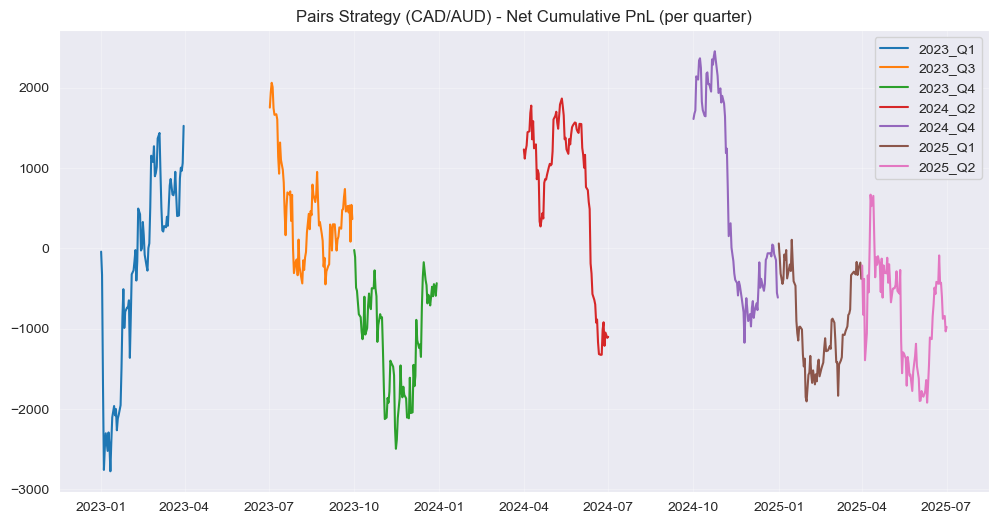

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import warnings

warnings.filterwarnings('ignore')


class Config:
    # File Path
    FILE_PATH = '../../preprocess/df_g2_processed.pkl'
    ASSETS = ['CAD', 'AUD']  # CAD = Y, AUD = X

    # Contract Specs
    SPECS = {
        'CAD': {'point_val': 100000.0, 'cost': 10.0},
        'AUD': {'point_val': 100000.0, 'cost': 10.0}
    }

    # Strategy Parameters
    WINDOW_BETA = 3500
    WINDOW_Z = 150
    ENTRY_THRESHOLD = 2.0
    EXIT_THRESHOLD = 0.5

    ANNUALIZATION = 252

    # Robustness knobs
    MIN_BETA_PERIOD = max(10, int(WINDOW_BETA * 0.1))
    MIN_Z_PERIOD = max(10, int(WINDOW_Z * 0.1))

    # Enforce only -1/0/1 positions
    MAX_LEVERAGE = 1

    # Break rules (Group 2 common assumptions)
    # Assuming break is 17:00 - 18:00 (adjust if different)
    BREAK_START = "17:00"  # break start
    BREAK_END = "18:00"    # break end
    EXIT_BEFORE_BREAK_MIN = 10   # exit positions this many minutes before break start (10 -> 16:50)
    NO_TRADE_AFTER_BREAK_MIN = 10  # do not trade for this many minutes after break end (10 -> 18:10)

    # Risk management (optional)
    MAX_HOLD_BARS = 500   # safety maximum holding bars (keep large if not used)
    STOP_LOSS = None      # e.g., -2000.0 (in $). None = disabled
    TAKE_PROFIT = None    # e.g., 2000.0 (in $). None = disabled

    # Slippage (per side) - default 0 to keep original costs only
    SLIPPAGE = 0.0

    EPS = 1e-8


def _ensure_datetime_index(df):
    if not isinstance(df.index, pd.DatetimeIndex):
        df = df.copy()
        df.index = pd.to_datetime(df.index)
    return df


# --------------------------
# 2. Data preparation
# --------------------------
def prepare_pairs_data(file_path, cfg):
    try:
        df = pd.read_pickle(file_path)
    except FileNotFoundError:
        print(f"[Error] File not found: {file_path}")
        return None

    req_cols = set(cfg.ASSETS + ['Quarter_ID'])
    if not req_cols.issubset(df.columns):
        missing = req_cols.difference(df.columns)
        print(f"[Error] Missing required columns: {missing}")
        return None

    data = df[cfg.ASSETS + ['Quarter_ID'] + (['Is_In_Sample'] if 'Is_In_Sample' in df.columns else [])].copy()
    if 'Is_In_Sample' not in data.columns:
        data['Is_In_Sample'] = True

    data = _ensure_datetime_index(data)

    print("[Info] Calculating Beta & Z-Score (robust, per quarter)...")
    print(f"  WINDOW_BETA = {cfg.WINDOW_BETA}, WINDOW_Z = {cfg.WINDOW_Z}")
    print(f"  MIN_BETA_PERIOD = {cfg.MIN_BETA_PERIOD}, MIN_Z_PERIOD = {cfg.MIN_Z_PERIOD}")

    def calc_metrics(group):
        g = group.copy()
        if len(g) == 0:
            return g

        y = g['CAD'] * cfg.SPECS['CAD']['point_val']
        x = g['AUD'] * cfg.SPECS['AUD']['point_val']

        # rolling covariance/variance with min_periods
        cov = x.rolling(window=cfg.WINDOW_BETA, min_periods=cfg.MIN_BETA_PERIOD).cov(y)
        var = x.rolling(window=cfg.WINDOW_BETA, min_periods=cfg.MIN_BETA_PERIOD).var()
        var_safe = var.copy()
        var_safe[var_safe.abs() < cfg.EPS] = np.nan
        beta = cov / var_safe
        beta = beta.replace([np.inf, -np.inf], np.nan).ffill().bfill().fillna(1.0)

        spread = y - beta * x

        # rolling z using fixed WINDOW_Z (safe)
        spread_mean = spread.rolling(window=cfg.WINDOW_Z, min_periods=cfg.MIN_Z_PERIOD).mean()
        spread_std = spread.rolling(window=cfg.WINDOW_Z, min_periods=cfg.MIN_Z_PERIOD).std()
        spread_std[spread_std.abs() < 1e-12] = np.nan
        z = (spread - spread_mean) / spread_std

        g.loc[:, 'Beta'] = beta.values
        g.loc[:, 'Spread'] = spread.values
        g.loc[:, 'Z_Score'] = z.values

        return g

    data_out = data.groupby('Quarter_ID', group_keys=False).apply(calc_metrics)

    n_total = len(data_out)
    n_z = data_out['Z_Score'].notna().sum()
    print(f"[Info] Rows total: {n_total}, rows with Z_Score: {n_z}")

    return data_out


# --------------------------
# 3. Strategy logic (with break rules & no leverage)
# --------------------------
def _time_in_break_window(ts, cfg):
    # ts is a Timestamp
    t = ts.time()
    # compute break window boundaries as times
    break_start = (pd.to_datetime(cfg.BREAK_START)).time()
    break_end = (pd.to_datetime(cfg.BREAK_END)).time()

    # compute exit-before and resume-after times
    # convert to datetime on same day for minute arithmetic
    day = ts.normalize()
    bstart_dt = pd.to_datetime(f"{day.date()} {cfg.BREAK_START}")
    bstart_exit = bstart_dt - pd.Timedelta(minutes=cfg.EXIT_BEFORE_BREAK_MIN)
    bend_dt = pd.to_datetime(f"{day.date()} {cfg.BREAK_END}")
    bend_resume = bend_dt + pd.Timedelta(minutes=cfg.NO_TRADE_AFTER_BREAK_MIN)

    # return True if ts is within [bstart_exit, bend_resume)
    return (ts >= bstart_exit) and (ts < bend_resume)


def run_pairs_strategy(df, cfg):
    data = df.copy()
    if data.empty:
        print("[Warning] Empty DataFrame passed to strategy.")
        return data

    data = _ensure_datetime_index(data)

    z = data['Z_Score'].values
    in_sample = data['Is_In_Sample'].values if 'Is_In_Sample' in data.columns else np.ones(len(data), dtype=bool)

    pos_cad = np.zeros(len(data), dtype=int)
    pos_aud = np.zeros(len(data), dtype=int)

    curr_cad = 0
    curr_aud = 0
    entry_index = None
    entry_price = None  # tuple (CAD_price, AUD_price) at entry for MTM stop-loss

    print(f"[Info] Running pairs strategy with break-window rules and unit positions (-1/0/1). ENTRY={cfg.ENTRY_THRESHOLD}, EXIT={cfg.EXIT_THRESHOLD}")

    for i, ts in enumerate(data.index):
        if not in_sample[i]:
            # force flat
            curr_cad = 0
            curr_aud = 0
            entry_index = None
            entry_price = None
            pos_cad[i] = 0
            pos_aud[i] = 0
            continue

        # If we're in break window (from exit-before to resume-after), force flat and don't allow entries
        in_break = _time_in_break_window(ts, cfg)

        zi = z[i]
        # if NaN or in_break, either hold=flat or keep pos -> but rule says "do not hold positions during breaks",
        # so we must close at the first timestamp that falls into the break-window.
        if in_break:
            curr_cad = 0
            curr_aud = 0
            entry_index = None
            entry_price = None
            pos_cad[i] = 0
            pos_aud[i] = 0
            continue

        # If z is NaN, hold existing (but should not be in break)
        if np.isnan(zi):
            pos_cad[i] = curr_cad
            pos_aud[i] = curr_aud
            continue

        # If currently flat, check entry signals (but only allowed outside break window)
        if curr_cad == 0 and curr_aud == 0:
            if zi > cfg.ENTRY_THRESHOLD:
                curr_cad = -1
                curr_aud = 1
                entry_index = i
                entry_price = (data['CAD'].iloc[i], data['AUD'].iloc[i])
            elif zi < -cfg.ENTRY_THRESHOLD:
                curr_cad = 1
                curr_aud = -1
                entry_index = i
                entry_price = (data['CAD'].iloc[i], data['AUD'].iloc[i])
        else:
            # currently in a trade: check plain exit by z threshold
            if abs(zi) < cfg.EXIT_THRESHOLD:
                curr_cad = 0
                curr_aud = 0
                entry_index = None
                entry_price = None
            else:
                # optional stop-loss / take-profit based on mark-to-market since entry
                if entry_price is not None and (cfg.STOP_LOSS is not None or cfg.TAKE_PROFIT is not None):
                    # compute MTM pnl of pair since entry in $:
                    # CAD leg pnl + AUD leg pnl
                    cad_pnl = curr_cad * (data['CAD'].iloc[i] - entry_price[0]) * cfg.SPECS['CAD']['point_val']
                    aud_pnl = curr_aud * (data['AUD'].iloc[i] - entry_price[1]) * cfg.SPECS['AUD']['point_val']
                    mtm = cad_pnl + aud_pnl
                    if cfg.STOP_LOSS is not None and mtm <= cfg.STOP_LOSS:
                        curr_cad = 0
                        curr_aud = 0
                        entry_index = None
                        entry_price = None
                    elif cfg.TAKE_PROFIT is not None and mtm >= cfg.TAKE_PROFIT:
                        curr_cad = 0
                        curr_aud = 0
                        entry_index = None
                        entry_price = None
                # also cap maximum holding bars if desired
                # (we can implement tracking of holding duration if required)

        pos_cad[i] = int(np.clip(curr_cad, -1, 1))
        pos_aud[i] = int(np.clip(curr_aud, -1, 1))

    # Lag positions by 1 bar to simulate execution on next bar
    data['Pos_CAD'] = pd.Series(pos_cad, index=data.index).shift(1).fillna(0).astype(int)
    data['Pos_AUD'] = pd.Series(pos_aud, index=data.index).shift(1).fillna(0).astype(int)

    n_trades = (data['Pos_CAD'].diff().abs().sum() + data['Pos_AUD'].diff().abs().sum()) / 2.0
    print(f"[Info] Total trade events (approx): {n_trades}")

    return data


# --------------------------
# 4. P&L calculation & aggregation
# --------------------------
def calculate_metrics(data, cfg):
    df = data.copy()
    if df.empty:
        return pd.DataFrame()

    df['dPrice_CAD'] = df['CAD'].diff()
    df['dPrice_AUD'] = df['AUD'].diff()

    df['Gross_PnL_CAD'] = df['Pos_CAD'] * df['dPrice_CAD'] * cfg.SPECS['CAD']['point_val']
    df['Gross_PnL_AUD'] = df['Pos_AUD'] * df['dPrice_AUD'] * cfg.SPECS['AUD']['point_val']
    df['Gross_PnL_Total'] = df['Gross_PnL_CAD'].fillna(0) + df['Gross_PnL_AUD'].fillna(0)

    df['Trades_CAD'] = df['Pos_CAD'].diff().abs().fillna(0)
    df['Trades_AUD'] = df['Pos_AUD'].diff().abs().fillna(0)

    df['Cost_Total'] = (df['Trades_CAD'] * (cfg.SPECS['CAD']['cost'] + cfg.SLIPPAGE)) + \
                       (df['Trades_AUD'] * (cfg.SPECS['AUD']['cost'] + cfg.SLIPPAGE))

    df['Net_PnL_Total'] = df['Gross_PnL_Total'] - df['Cost_Total']
    df['Total_Trades'] = df['Trades_CAD'] + df['Trades_AUD']

    daily_stats = df.resample('D').agg({
        'Gross_PnL_Total': 'sum',
        'Net_PnL_Total': 'sum',
        'Total_Trades': 'sum',
        'Trades_CAD': 'sum',
        'Trades_AUD': 'sum',
        'Quarter_ID': 'last',
        'Is_In_Sample': 'last'
    })

    daily_stats = daily_stats[daily_stats['Quarter_ID'].notna()]
    daily_stats = daily_stats[daily_stats['Is_In_Sample'] == True]

    return daily_stats


# --------------------------
# 5./6. Reporting (same as before)
# --------------------------
def generate_quarterly_stats(daily_df, cfg):
    if daily_df.empty:
        return pd.DataFrame()

    quarters = sorted(daily_df['Quarter_ID'].unique())
    stats_list = []

    for q in quarters:
        d_q = daily_df[daily_df['Quarter_ID'] == q].copy()
        if len(d_q) == 0:
            continue

        gross_cum_pnl = d_q['Gross_PnL_Total'].sum()
        net_cum_pnl = d_q['Net_PnL_Total'].sum()

        mean_g = d_q['Gross_PnL_Total'].mean()
        std_g = d_q['Gross_PnL_Total'].std()
        gross_sr = (mean_g / std_g * np.sqrt(cfg.ANNUALIZATION)) if (std_g and not np.isnan(std_g)) else 0

        mean_n = d_q['Net_PnL_Total'].mean()
        std_n = d_q['Net_PnL_Total'].std()
        net_sr = (mean_n / std_n * np.sqrt(cfg.ANNUALIZATION)) if (std_n and not np.isnan(std_n)) else 0

        ann_vol_n = std_n * np.sqrt(cfg.ANNUALIZATION) if (std_n and not np.isnan(std_n)) else 0

        years = len(d_q) / cfg.ANNUALIZATION if cfg.ANNUALIZATION > 0 else 1.0

        equity_n = d_q['Net_PnL_Total'].cumsum()
        max_dd_n = (equity_n.cummax() - equity_n).max()
        net_cr = (net_cum_pnl / years / max_dd_n) if (max_dd_n and max_dd_n > 0) else 0

        trades_cad = d_q['Trades_CAD'].sum()
        trades_aud = d_q['Trades_AUD'].sum()
        av_ntrades = d_q['Total_Trades'].mean()

        abs_pnl_scaled = abs(net_cum_pnl) / 1000.0
        log_term = np.log(abs_pnl_scaled) if abs_pnl_scaled > 0 else 0
        term_2 = max(0, log_term)
        stat = (net_sr - 0.5) * term_2

        stats_list.append({
            'Quarter': q,
            'Gross SR': gross_sr,
            'Net SR': net_sr,
            'Ann. Vol ($)': ann_vol_n,
            'Gross CR': 0.0 if np.isnan(gross_sr) else gross_sr,
            'Net CR': net_cr,
            'Gross CumP&L': gross_cum_pnl,
            'Net CumP&L': net_cum_pnl,
            'Trades (CAD)': trades_cad,
            'Trades (AUD)': trades_aud,
            'Av. Trades': av_ntrades,
            'Stat': stat
        })

    return pd.DataFrame(stats_list)


def plot_equity_curve(daily_stats):
    if daily_stats is None or daily_stats.empty:
        return
    quarters = sorted(daily_stats['Quarter_ID'].unique())
    plt.figure(figsize=(12, 6))
    for q in quarters:
        d_q = daily_stats[daily_stats['Quarter_ID'] == q].copy()
        plt.plot(d_q.index, d_q['Net_PnL_Total'].cumsum(), label=q)
    plt.title('Pairs Strategy (CAD/AUD) - Net Cumulative PnL (per quarter)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


if __name__ == "__main__":
    cfg = Config()
    df_prep = prepare_pairs_data(cfg.FILE_PATH, cfg)

    if df_prep is None or df_prep.empty:
        print("[Error] No data after preparation. Exiting.")
    else:
        df_res = run_pairs_strategy(df_prep, cfg)
        daily_data = calculate_metrics(df_res, cfg)
        stats_table = generate_quarterly_stats(daily_data, cfg)

        print("\n" + "=" * 80)
        print(" PERFORMANCE REPORT: Pairs Strategy (CAD/AUD) with Break Rules")
        print("=" * 80)

        if not stats_table.empty:
            total_score = stats_table['Stat'].sum()
            total_gross_pnl = stats_table['Gross CumP&L'].sum()
            total_net_pnl = stats_table['Net CumP&L'].sum()
            total_trades_cad = stats_table['Trades (CAD)'].sum()
            total_trades_aud = stats_table['Trades (AUD)'].sum()

            std_global = daily_data['Net_PnL_Total'].std()
            vol_global = std_global * np.sqrt(cfg.ANNUALIZATION) if not np.isnan(std_global) else 0.0

            display_df = stats_table.copy()
            sum_row = pd.DataFrame([{
                'Quarter': 'TOTAL',
                'Gross SR': np.nan,
                'Net SR': np.nan,
                'Ann. Vol ($)': vol_global,
                'Gross CR': np.nan,
                'Net CR': np.nan,
                'Gross CumP&L': total_gross_pnl,
                'Net CumP&L': total_net_pnl,
                'Trades (CAD)': total_trades_cad,
                'Trades (AUD)': total_trades_aud,
                'Av. Trades': stats_table['Av. Trades'].mean(),
                'Stat': total_score
            }])

            display_df = pd.concat([display_df, sum_row], ignore_index=True)
            display(display_df)

            print(f"\n{'=' * 40}")
            print(f" TOTAL RANKING SCORE: {total_score:.4f}")
            print(f"{'=' * 40}")

            plot_equity_curve(daily_data)
        else:
            print("⚠️ No statistics generated.")


[Info] Calculating Beta & Z-Score (improved: EWM beta + robust Z)...
  WINDOW_BETA = 2000, WINDOW_Z = 100
  MIN_BETA_PERIOD = 200, MIN_Z_PERIOD = 10
[Info] Rows total: 122630, rows with Z_Score: 117576
[Info] Running improved pairs strategy. ENTRY=2.5, EXIT=0.0
[Info] Total trade events (approx): 333.0

 PERFORMANCE REPORT: Pairs Strategy (CAD/AUD) with Break Rules


,Quarter,Gross SR,Net SR,Ann. Vol ($),Gross CR,Net CR,Gross CumP&L,Net CumP&L,Trades (CAD),Trades (AUD),Av. Trades,Stat
0,2023_Q1,0.680055,-0.368725,2831.448651,0.680055,-0.688934,596.849387,-323.150613,46.0,46.0,1.179487,-0.000000
1,2023_Q3,0.393253,-0.968005,2231.765073,0.393253,-2.085782,271.317139,-668.682861,47.0,47.0,1.205128,-0.000000
2,2023_Q4,-0.211021,-1.072328,2772.451928,-0.211021,-1.354513,-180.207824,-920.207824,37.0,37.0,0.948718,-0.000000
3,2024_Q2,-2.717191,-4.626242,1532.491835,-2.717191,-3.189873,-1222.557955,-2222.557955,50.0,50.0,1.265823,-4.094118
4,2024_Q4,1.012103,0.194672,2973.520789,1.012103,0.436904,941.468227,181.468227,38.0,38.0,0.962025,-0.000000
5,2025_Q1,1.059185,-0.986372,1907.199260,1.059185,-1.746519,605.186724,-574.813276,59.0,59.0,1.532468,-0.000000
6,2025_Q2,-0.954336,-2.005521,3381.730070,-0.954336,-2.716433,-1006.144425,-2126.144425,56.0,56.0,1.417722,-1.889940
7,TOTAL,NaN,NaN,2582.999917,NaN,NaN,5.911273,-6654.088727,333.0,333.0,1.215910,-5.984059



 TOTAL RANKING SCORE: -5.9841


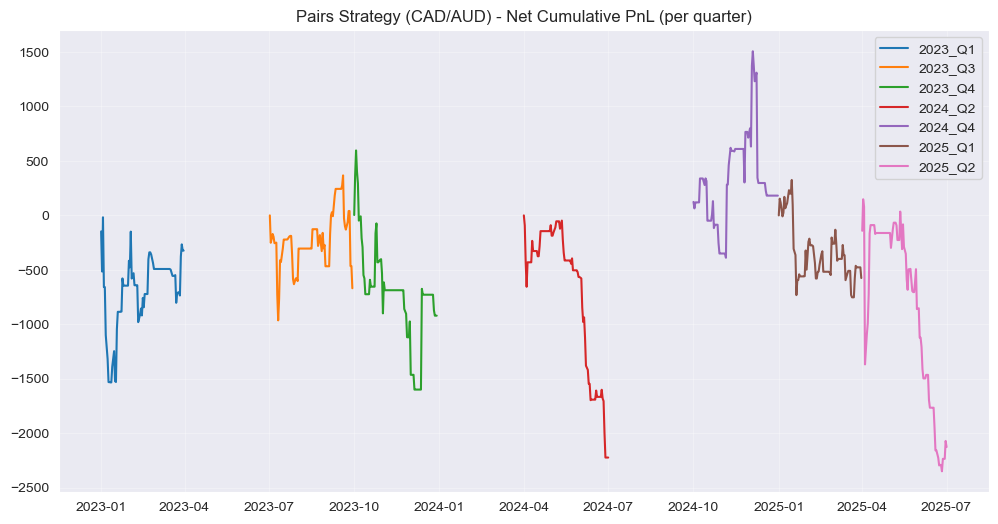

In [57]:
# 改良版ペア戦略（CAD/AUD） --- 元コードの構造を保持しつつ改良点を追加
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import warnings

warnings.filterwarnings('ignore')

class Config:
    # File Path
    FILE_PATH = '../../preprocess/df_g2_processed.pkl'
    ASSETS = ['CAD', 'AUD']  # CAD = Y, AUD = X

    # Contract Specs
    SPECS = {
        'CAD': {'point_val': 100000.0, 'cost': 10.0},
        'AUD': {'point_val': 100000.0, 'cost': 10.0}
    }

    # Strategy Parameters (tunable)
    WINDOW_BETA = 2000       # 短めにしてレジーム変化に追随（元は3500）
    WINDOW_Z = 100           # Z算出の窓（元は150）
    ENTRY_THRESHOLD = 2.5    # entry z
    EXIT_THRESHOLD = 0.0     # exit z
    ENTRY_CONFIRM_BARS = 1   # エントリー時に1バー確認（1 = 現在と前バーで同符号）
    MIN_EXPECTED_PNL = 500.0 # 期待P&Lがこれ未満ならエントリーしない（$）
    TARGET_RISK_PER_TRADE = 2000.0  # 将来的にポジションサイズ化する場合の目標リスク（未使用：参考値）

    ANNUALIZATION = 252

    # Robustness knobs
    MIN_BETA_PERIOD = max(10, int(WINDOW_BETA * 0.1))
    MIN_Z_PERIOD = max(10, int(WINDOW_Z * 0.1))

    # Enforce only -1/0/1 positions
    MAX_LEVERAGE = 1

    # Break rules
    BREAK_START = "17:00"
    BREAK_END = "18:00"
    EXIT_BEFORE_BREAK_MIN = 10
    NO_TRADE_AFTER_BREAK_MIN = 10

    # Risk management
    MAX_HOLD_BARS = 200   # 最大保有バー数（安全のためやや小さめ）
    STOP_LOSS = None      # e.g., -2000.0
    TAKE_PROFIT = None    # e.g., 2000.0

    # Slippage (per side)
    SLIPPAGE = 0.0

    EPS = 1e-8

# --------------------------------------------------------
# Utility: ensure datetime index
# --------------------------------------------------------
def _ensure_datetime_index(df):
    if not isinstance(df.index, pd.DatetimeIndex):
        df = df.copy()
        df.index = pd.to_datetime(df.index)
    return df

# --------------------------------------------------------
# 1) Data preparation: improved beta + robust Z-score
# --------------------------------------------------------
def prepare_pairs_data(file_path, cfg):
    try:
        df = pd.read_pickle(file_path)
    except FileNotFoundError:
        print(f"[Error] File not found: {file_path}")
        return None

    req_cols = set(cfg.ASSETS + ['Quarter_ID'])
    if not req_cols.issubset(df.columns):
        missing = req_cols.difference(df.columns)
        print(f"[Error] Missing required columns: {missing}")
        return None

    data = df[cfg.ASSETS + ['Quarter_ID'] + (['Is_In_Sample'] if 'Is_In_Sample' in df.columns else [])].copy()
    if 'Is_In_Sample' not in data.columns:
        data['Is_In_Sample'] = True

    data = _ensure_datetime_index(data)

    print("[Info] Calculating Beta & Z-Score (improved: EWM beta + robust Z)...")
    print(f"  WINDOW_BETA = {cfg.WINDOW_BETA}, WINDOW_Z = {cfg.WINDOW_Z}")
    print(f"  MIN_BETA_PERIOD = {cfg.MIN_BETA_PERIOD}, MIN_Z_PERIOD = {cfg.MIN_Z_PERIOD}")

    def calc_metrics(group):
        g = group.copy()
        if len(g) == 0:
            return g

        # prices scaled to $ (point_val)
        y = g['CAD'] * cfg.SPECS['CAD']['point_val']
        x = g['AUD'] * cfg.SPECS['AUD']['point_val']

        # --------
        # EWM-based beta (more responsive than long rolling)
        # cov = E[x*y] - E[x]*E[y]
        span = cfg.WINDOW_BETA
        x_ewm = x.ewm(span=span, min_periods=cfg.MIN_BETA_PERIOD).mean()
        y_ewm = y.ewm(span=span, min_periods=cfg.MIN_BETA_PERIOD).mean()
        xy_ewm = (x * y).ewm(span=span, min_periods=cfg.MIN_BETA_PERIOD).mean()
        xx_ewm = (x * x).ewm(span=span, min_periods=cfg.MIN_BETA_PERIOD).mean()

        cov = xy_ewm - x_ewm * y_ewm
        var = xx_ewm - x_ewm * x_ewm

        var_safe = var.copy()
        var_safe[var_safe.abs() < cfg.EPS] = np.nan
        beta = cov / var_safe

        # forward-fill previous valid beta (don't hard-default to 1.0)
        beta = beta.replace([np.inf, -np.inf], np.nan).ffill().bfill()

        # Protect from extreme beta values (clamp)
        beta = beta.clip(lower=-10.0, upper=10.0)

        spread = y - beta * x

        # Robust spread volatility: rolling std but fallback to MAD if needed
        spread_mean = spread.rolling(window=cfg.WINDOW_Z, min_periods=cfg.MIN_Z_PERIOD).mean()
        spread_std_roll = spread.rolling(window=cfg.WINDOW_Z, min_periods=cfg.MIN_Z_PERIOD).std()

        # MAD (robust) scaled to std-equivalent
        def mad(arr):
            m = np.nanmedian(arr)
            return np.nanmedian(np.abs(arr - m)) * 1.4826

        spread_mad = spread.rolling(window=cfg.WINDOW_Z, min_periods=cfg.MIN_Z_PERIOD).apply(mad, raw=True)

        # Prefer rolling std, but if tiny or NaN use MAD
        spread_std = spread_std_roll.copy()
        use_mad = (spread_std_roll.isna()) | (spread_std_roll < 1e-6)
        spread_std[use_mad] = spread_mad[use_mad]

        # final safe std
        spread_std[spread_std.abs() < cfg.EPS] = np.nan

        z = (spread - spread_mean) / spread_std

        g.loc[:, 'Beta'] = beta.values
        g.loc[:, 'Spread'] = spread.values
        g.loc[:, 'Z_Score'] = z.values
        g.loc[:, 'SpreadStd'] = spread_std.values  # 追加（エントリーフィルタに使う）

        return g

    data_out = data.groupby('Quarter_ID', group_keys=False).apply(calc_metrics)

    n_total = len(data_out)
    n_z = data_out['Z_Score'].notna().sum()
    print(f"[Info] Rows total: {n_total}, rows with Z_Score: {n_z}")

    return data_out

# --------------------------------------------------------
# 2) Break window helper (同じ実装)
# --------------------------------------------------------
def _time_in_break_window(ts, cfg):
    day = ts.normalize()
    bstart_dt = pd.to_datetime(f"{day.date()} {cfg.BREAK_START}")
    bstart_exit = bstart_dt - pd.Timedelta(minutes=cfg.EXIT_BEFORE_BREAK_MIN)
    bend_dt = pd.to_datetime(f"{day.date()} {cfg.BREAK_END}")
    bend_resume = bend_dt + pd.Timedelta(minutes=cfg.NO_TRADE_AFTER_BREAK_MIN)
    return (ts >= bstart_exit) and (ts < bend_resume)

# --------------------------------------------------------
# 3) Strategy logic: entry filters, confirmation, max hold bars
# --------------------------------------------------------
def run_pairs_strategy(df, cfg):
    data = df.copy()
    if data.empty:
        print("[Warning] Empty DataFrame passed to strategy.")
        return data

    data = _ensure_datetime_index(data)

    z = data['Z_Score'].values
    spread_std = data['SpreadStd'].values if 'SpreadStd' in data.columns else np.zeros(len(data))
    in_sample = data['Is_In_Sample'].values if 'Is_In_Sample' in data.columns else np.ones(len(data), dtype=bool)

    pos_cad = np.zeros(len(data), dtype=int)
    pos_aud = np.zeros(len(data), dtype=int)

    curr_cad = 0
    curr_aud = 0
    entry_index = None
    entry_price = None
    hold_bars = 0

    print(f"[Info] Running improved pairs strategy. ENTRY={cfg.ENTRY_THRESHOLD}, EXIT={cfg.EXIT_THRESHOLD}")

    for i, ts in enumerate(data.index):
        if not in_sample[i]:
            # force flat
            curr_cad = 0
            curr_aud = 0
            entry_index = None
            entry_price = None
            hold_bars = 0
            pos_cad[i] = 0
            pos_aud[i] = 0
            continue

        # break window => force flat
        in_break = _time_in_break_window(ts, cfg)
        if in_break:
            curr_cad = 0
            curr_aud = 0
            entry_index = None
            entry_price = None
            hold_bars = 0
            pos_cad[i] = 0
            pos_aud[i] = 0
            continue

        zi = z[i]
        sstd = spread_std[i] if not np.isnan(spread_std[i]) else np.nan

        # NaN z -> hold existing (but not in break)
        if np.isnan(zi):
            pos_cad[i] = curr_cad
            pos_aud[i] = curr_aud
            continue

        # If currently flat, check entry signals (with confirmation & expected PnL filter)
        if curr_cad == 0 and curr_aud == 0:
            # entry candidates
            will_enter = False
            side = 0
            if zi > cfg.ENTRY_THRESHOLD:
                side = -1  # short CAD, long AUD
                will_enter = True
            elif zi < -cfg.ENTRY_THRESHOLD:
                side = 1
                will_enter = True

            if will_enter:
                # entry confirmation: require previous bar z has same sign (simple confirmation)
                ok_confirm = True
                if cfg.ENTRY_CONFIRM_BARS >= 1 and i - 1 >= 0:
                    prev_z = z[i - 1]
                    if np.isnan(prev_z) or np.sign(prev_z) != np.sign(zi):
                        ok_confirm = False

                # expected pnl filter: expected move ~ |z| * spread_std (dollars)
                expected_move = abs(zi) * (sstd if not np.isnan(sstd) else 0.0)
                per_side_cost = cfg.SPECS['CAD']['cost'] + cfg.SPECS['AUD']['cost']  # approximate round-trip proxy
                # require expected P&L to be meaningfully greater than costs
                ok_expected = expected_move >= max(cfg.MIN_EXPECTED_PNL, per_side_cost * 2.0)

                if ok_confirm and ok_expected:
                    if side == 1:
                        curr_cad = 1
                        curr_aud = -1
                    else:
                        curr_cad = -1
                        curr_aud = 1
                    entry_index = i
                    entry_price = (data['CAD'].iloc[i], data['AUD'].iloc[i])
                    hold_bars = 0
                else:
                    # skip entry (fail filters)
                    curr_cad = 0
                    curr_aud = 0
        else:
            # check exit by z threshold
            if abs(zi) < cfg.EXIT_THRESHOLD:
                curr_cad = 0
                curr_aud = 0
                entry_index = None
                entry_price = None
                hold_bars = 0
            else:
                # check stop-loss / take-profit if enabled
                if entry_price is not None and (cfg.STOP_LOSS is not None or cfg.TAKE_PROFIT is not None):
                    cad_pnl = curr_cad * (data['CAD'].iloc[i] - entry_price[0]) * cfg.SPECS['CAD']['point_val']
                    aud_pnl = curr_aud * (data['AUD'].iloc[i] - entry_price[1]) * cfg.SPECS['AUD']['point_val']
                    mtm = cad_pnl + aud_pnl
                    if cfg.STOP_LOSS is not None and mtm <= cfg.STOP_LOSS:
                        curr_cad = 0; curr_aud = 0; entry_index = None; entry_price = None; hold_bars = 0
                    elif cfg.TAKE_PROFIT is not None and mtm >= cfg.TAKE_PROFIT:
                        curr_cad = 0; curr_aud = 0; entry_index = None; entry_price = None; hold_bars = 0

                # enforce max holding bars
                hold_bars += 1
                if hold_bars >= cfg.MAX_HOLD_BARS:
                    curr_cad = 0
                    curr_aud = 0
                    entry_index = None
                    entry_price = None
                    hold_bars = 0

        pos_cad[i] = int(np.clip(curr_cad, -1, 1))
        pos_aud[i] = int(np.clip(curr_aud, -1, 1))

    # Lag positions by 1 bar to simulate next-bar execution
    data['Pos_CAD'] = pd.Series(pos_cad, index=data.index).shift(1).fillna(0).astype(int)
    data['Pos_AUD'] = pd.Series(pos_aud, index=data.index).shift(1).fillna(0).astype(int)

    n_trades = (data['Pos_CAD'].diff().abs().sum() + data['Pos_AUD'].diff().abs().sum()) / 2.0
    print(f"[Info] Total trade events (approx): {n_trades}")

    return data

# --------------------------------------------------------
# 4) P&L & metrics (ほぼ同じ、安定化処理を追加)
# --------------------------------------------------------
def calculate_metrics(data, cfg):
    df = data.copy()
    if df.empty:
        return pd.DataFrame()

    df['dPrice_CAD'] = df['CAD'].diff()
    df['dPrice_AUD'] = df['AUD'].diff()

    df['Gross_PnL_CAD'] = df['Pos_CAD'] * df['dPrice_CAD'] * cfg.SPECS['CAD']['point_val']
    df['Gross_PnL_AUD'] = df['Pos_AUD'] * df['dPrice_AUD'] * cfg.SPECS['AUD']['point_val']
    df['Gross_PnL_Total'] = df['Gross_PnL_CAD'].fillna(0) + df['Gross_PnL_AUD'].fillna(0)

    df['Trades_CAD'] = df['Pos_CAD'].diff().abs().fillna(0)
    df['Trades_AUD'] = df['Pos_AUD'].diff().abs().fillna(0)

    df['Cost_Total'] = (df['Trades_CAD'] * (cfg.SPECS['CAD']['cost'] + cfg.SLIPPAGE)) + \
                       (df['Trades_AUD'] * (cfg.SPECS['AUD']['cost'] + cfg.SLIPPAGE))

    df['Net_PnL_Total'] = df['Gross_PnL_Total'] - df['Cost_Total']
    df['Total_Trades'] = df['Trades_CAD'] + df['Trades_AUD']

    daily_stats = df.resample('D').agg({
        'Gross_PnL_Total': 'sum',
        'Net_PnL_Total': 'sum',
        'Total_Trades': 'sum',
        'Trades_CAD': 'sum',
        'Trades_AUD': 'sum',
        'Quarter_ID': 'last',
        'Is_In_Sample': 'last'
    })

    daily_stats = daily_stats[daily_stats['Quarter_ID'].notna()]
    daily_stats = daily_stats[daily_stats['Is_In_Sample'] == True]

    return daily_stats

# --------------------------------------------------------
# 5) Reporting (小さな安定化)
# --------------------------------------------------------
def generate_quarterly_stats(daily_df, cfg):
    if daily_df.empty:
        return pd.DataFrame()

    quarters = sorted(daily_df['Quarter_ID'].unique())
    stats_list = []

    for q in quarters:
        d_q = daily_df[daily_df['Quarter_ID'] == q].copy()
        if len(d_q) == 0:
            continue

        gross_cum_pnl = d_q['Gross_PnL_Total'].sum()
        net_cum_pnl = d_q['Net_PnL_Total'].sum()

        mean_g = d_q['Gross_PnL_Total'].mean()
        std_g = d_q['Gross_PnL_Total'].std()
        gross_sr = (mean_g / std_g * np.sqrt(cfg.ANNUALIZATION)) if (std_g and not np.isnan(std_g) and std_g>0) else 0.0

        mean_n = d_q['Net_PnL_Total'].mean()
        std_n = d_q['Net_PnL_Total'].std()
        net_sr = (mean_n / std_n * np.sqrt(cfg.ANNUALIZATION)) if (std_n and not np.isnan(std_n) and std_n>0) else 0.0

        ann_vol_n = std_n * np.sqrt(cfg.ANNUALIZATION) if (std_n and not np.isnan(std_n)) else 0.0

        years = len(d_q) / cfg.ANNUALIZATION if cfg.ANNUALIZATION > 0 else 1.0

        equity_n = d_q['Net_PnL_Total'].cumsum()
        max_dd_n = (equity_n.cummax() - equity_n).max() if not equity_n.empty else 0.0
        net_cr = (net_cum_pnl / years / max_dd_n) if (max_dd_n and max_dd_n > 0) else 0.0

        trades_cad = d_q['Trades_CAD'].sum()
        trades_aud = d_q['Trades_AUD'].sum()
        av_ntrades = d_q['Total_Trades'].mean()

        abs_pnl_scaled = abs(net_cum_pnl) / 1000.0
        log_term = np.log(abs_pnl_scaled) if abs_pnl_scaled > 0 else 0
        term_2 = max(0, log_term)
        stat = (net_sr - 0.5) * term_2

        stats_list.append({
            'Quarter': q,
            'Gross SR': gross_sr,
            'Net SR': net_sr,
            'Ann. Vol ($)': ann_vol_n,
            'Gross CR': 0.0 if np.isnan(gross_sr) else gross_sr,
            'Net CR': net_cr,
            'Gross CumP&L': gross_cum_pnl,
            'Net CumP&L': net_cum_pnl,
            'Trades (CAD)': trades_cad,
            'Trades (AUD)': trades_aud,
            'Av. Trades': av_ntrades,
            'Stat': stat
        })

    return pd.DataFrame(stats_list)


def plot_equity_curve(daily_stats):
    if daily_stats is None or daily_stats.empty:
        return
    quarters = sorted(daily_stats['Quarter_ID'].unique())
    plt.figure(figsize=(12, 6))
    for q in quarters:
        d_q = daily_stats[daily_stats['Quarter_ID'] == q].copy()
        plt.plot(d_q.index, d_q['Net_PnL_Total'].cumsum(), label=q)
    plt.title('Pairs Strategy (CAD/AUD) - Net Cumulative PnL (per quarter)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


if __name__ == "__main__":
    cfg = Config()
    df_prep = prepare_pairs_data(cfg.FILE_PATH, cfg)

    if df_prep is None or df_prep.empty:
        print("[Error] No data after preparation. Exiting.")
    else:
        df_res = run_pairs_strategy(df_prep, cfg)
        daily_data = calculate_metrics(df_res, cfg)
        stats_table = generate_quarterly_stats(daily_data, cfg)

        print("\n" + "=" * 80)
        print(" PERFORMANCE REPORT: Pairs Strategy (CAD/AUD) with Break Rules")
        print("=" * 80)

        if not stats_table.empty:
            total_score = stats_table['Stat'].sum()
            total_gross_pnl = stats_table['Gross CumP&L'].sum()
            total_net_pnl = stats_table['Net CumP&L'].sum()
            total_trades_cad = stats_table['Trades (CAD)'].sum()
            total_trades_aud = stats_table['Trades (AUD)'].sum()

            std_global = daily_data['Net_PnL_Total'].std()
            vol_global = std_global * np.sqrt(cfg.ANNUALIZATION) if not np.isnan(std_global) else 0.0

            display_df = stats_table.copy()
            sum_row = pd.DataFrame([{
                'Quarter': 'TOTAL',
                'Gross SR': np.nan,
                'Net SR': np.nan,
                'Ann. Vol ($)': vol_global,
                'Gross CR': np.nan,
                'Net CR': np.nan,
                'Gross CumP&L': total_gross_pnl,
                'Net CumP&L': total_net_pnl,
                'Trades (CAD)': total_trades_cad,
                'Trades (AUD)': total_trades_aud,
                'Av. Trades': stats_table['Av. Trades'].mean(),
                'Stat': total_score
            }])

            display_df = pd.concat([display_df, sum_row], ignore_index=True)
            display(display_df)

            print(f"\n{'=' * 40}")
            print(f" TOTAL RANKING SCORE: {total_score:.4f}")
            print(f"{'=' * 40}")

            plot_equity_curve(daily_data)
        else:
            print("⚠️ No statistics generated.")